In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) #set default figure size
sns.set_theme(style="whitegrid") #set default seaborn theme

In [2]:
# load data
cboe_quotes = np.loadtxt('CBOEQuotes.txt')
print(cboe_quotes[:10])

[[650.  232.3 234.3]
 [675.  207.5 209.5]
 [700.  182.9 184.9]
 [725.  158.5 160.5]
 [750.  134.4 136.4]
 [760.  124.9 126.9]
 [765.  120.1 122.1]
 [775.  110.8 112.8]
 [800.   87.9  89.9]
 [810.   79.   81. ]]


In [3]:
# parameters
T = 30 / 365  # 30 days to maturity
S0 = 884.25  # current stock price
q = 0.0176  # dividend yield
r = 0.0125  # risk-free rate
K = cboe_quotes[:, 0]  # strike prices
bid = cboe_quotes[:, 1]  # bid prices
ask = cboe_quotes[:, 2]  # ask prices
market = (bid + ask) / 2  # average of bid and ask prices

## Bisection Method

In [4]:
def Black_Scholes_Call(S, K, r, q, T, sigma):
    """Black-Scholes call option price.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        sigma (float): volatility

    Returns:
        float: call option price
    """
    if sigma == 0:
        return max(S * np.exp(-q * T) - K * np.exp(-r * T), 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [5]:
def implied_volatility_bisection(S, K, r, q, T, C, tol=1e-6, max_iter=1000):
    """Implied volatility using bisection method.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        C (float): call option price
        tol (float, optional): tolerance. Defaults to 1e-6.
        max_iter (int, optional): maximum number of iterations. Defaults to 1000.

    Returns:
        float: approximate implied volatility
    """
    if C < max(S * np.exp(-q * T) - K * np.exp(-r * T), 0):
        print("Option price $" + str(C) +
              " violates the arbitrage bound (too low).")
        return np.nan
    elif C > S * np.exp(-q * T):
        print("Option price $" + str(C) +
              " violates the arbitrage bound (too high).")
        return np.nan

    lower = 0
    upper = 1
    while Black_Scholes_Call(S, K, r, q, T, upper) - C < 0:
        upper *= 2
    guess = (lower + upper) / 2

    while upper - lower > tol and max_iter > 0:
        diff = Black_Scholes_Call(S, K, r, q, T, guess) - C
        if diff < 0:
            lower = guess
        else:
            upper = guess
        guess = (lower + upper) / 2
        max_iter -= 1
    return guess

In [6]:
iv_bid_bisection = np.array([implied_volatility_bisection(
    S0, K[i], r, q, T, bid[i]) for i in range(len(K))])
iv_ask_bisection = np.array([implied_volatility_bisection(
    S0, K[i], r, q, T, ask[i]) for i in range(len(K))])
iv_market_bisection = np.array([implied_volatility_bisection(
    S0, K[i], r, q, T, market[i]) for i in range(len(K))])
iv_bisection = np.stack(
    (iv_bid_bisection, iv_ask_bisection, iv_market_bisection), axis=1)

print(" ")
print("Implied Volatility using Bisection Method:")
print(iv_bisection[:10])

Option price $232.3 violates the arbitrage bound (too low).
Option price $207.5 violates the arbitrage bound (too low).
Option price $182.9 violates the arbitrage bound (too low).
Option price $158.5 violates the arbitrage bound (too low).
Option price $233.3 violates the arbitrage bound (too low).
Option price $208.5 violates the arbitrage bound (too low).
 
Implied Volatility using Bisection Method:
[[       nan 0.5046258         nan]
 [       nan 0.46623468        nan]
 [       nan 0.43761778 0.33935022]
 [       nan 0.41029119 0.35418081]
 [0.29337454 0.38361406 0.34674215]
 [0.30126905 0.37372255 0.34213114]
 [0.29936171 0.36651659 0.33675146]
 [0.30273294 0.35829592 0.33274221]
 [0.29391813 0.33256769 0.31397581]
 [0.28782797 0.32195616 0.30536699]]


## Newton Method

In [7]:
def vega(S, K, r, q, T, sigma):
    """Vega of a call option.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        sigma (float): volatility

    Returns:
        float: vega
    """
    if sigma == 0:
        return 0
    else:
        d1 = (np.log(S / K) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

In [8]:
def implied_volatility_newton(S, K, r, q, T, C, sigma_guess=0.5, tol=1e-6, max_iter=1000):
    """Implied volatility using Newton's method.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        C (float): call option price
        sigma_guess (float): initial guess of volatility
        tol (float): tolerance. Defaults to 1e-6.
        max_iter (int): maximum number of iterations. Defaults to 1000.

    Returns:
        float: approximate implied volatility
    """
    if C < max(S * np.exp(-q * T) - K * np.exp(-r * T), 0):
        print("Option price $" + str(C) +
              " violates the arbitrage bound (too low).")
        return np.nan
    elif C > S * np.exp(-q * T):
        print("Option price $" + str(C) +
              " violates the arbitrage bound (too high).")
        return np.nan

    sigma = sigma_guess
    while max_iter > 0:
        diff = Black_Scholes_Call(S, K, r, q, T, sigma) - C
        if abs(diff) < tol:
            break
        sigma -= diff / vega(S, K, r, q, T, sigma)
        max_iter -= 1
    return sigma

In [9]:
iv_bid_newton = np.array([implied_volatility_newton(
    S0, K[i], r, q, T, bid[i]) for i in range(len(K))])
iv_ask_newton = np.array([implied_volatility_newton(
    S0, K[i], r, q, T, ask[i]) for i in range(len(K))])
iv_market_newton = np.array([implied_volatility_newton(
    S0, K[i], r, q, T, market[i]) for i in range(len(K))])
iv_newton = np.stack((iv_bid_newton, iv_ask_newton, iv_market_newton), axis=1)

print(" ")
print("Implied Volatility using Newton's Method:")
print(iv_newton[:10])

Option price $232.3 violates the arbitrage bound (too low).
Option price $207.5 violates the arbitrage bound (too low).
Option price $182.9 violates the arbitrage bound (too low).
Option price $158.5 violates the arbitrage bound (too low).
Option price $233.3 violates the arbitrage bound (too low).
Option price $208.5 violates the arbitrage bound (too low).
 
Implied Volatility using Newton's Method:
[[       nan 0.50462541        nan]
 [       nan 0.46623491        nan]
 [       nan 0.43761761 0.33935068]
 [       nan 0.41029135 0.35418082]
 [0.29337411 0.38361417 0.34674248]
 [0.30126863 0.37372226 0.34213076]
 [0.29936161 0.36651695 0.33675189]
 [0.3027326  0.3582963  0.33274255]
 [0.29391836 0.3325675  0.31397606]
 [0.28782754 0.32195602 0.30536718]]


## Implied Volatility

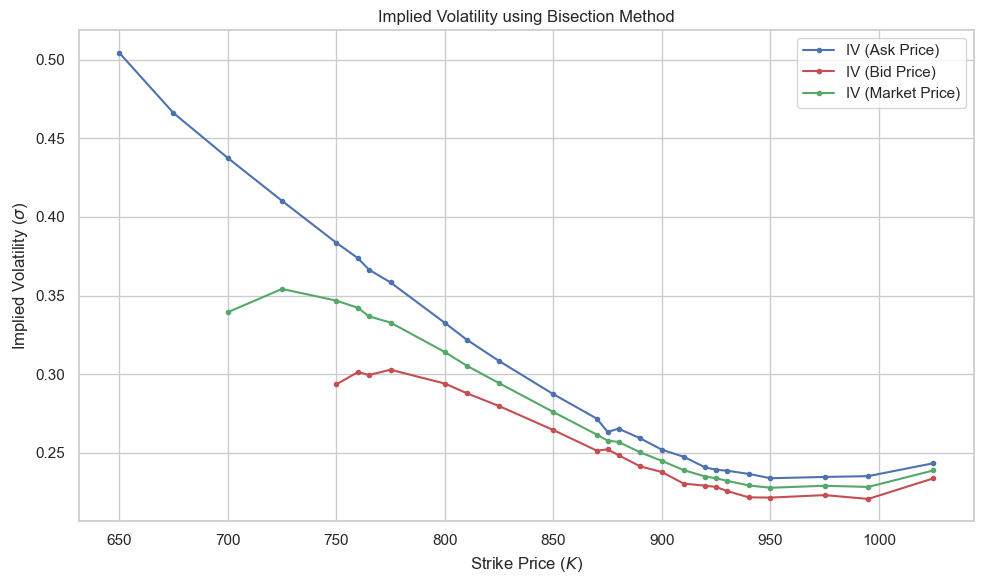

In [10]:
# Comparison of Different Prices Used
fig, ax = plt.subplots()
ax.plot(K, iv_ask_bisection, 'b.-', label='IV (Ask Price)')
ax.plot(K, iv_bid_bisection, 'r.-', label='IV (Bid Price)')
ax.plot(K, iv_market_bisection, 'g.-', label='IV (Market Price)')
ax.legend()
ax.set_title('Implied Volatility using Bisection Method')
ax.set_xlabel(r'Strike Price ($K$)')
ax.set_ylabel(r'Implied Volatility ($\sigma$)')
plt.tight_layout()
plt.show()

The missing values in the implied volatility that calculated using bid and average price are those that violate the no-arbitrage bounds:
$$
C \geq S e^{-qT} - K e^{-rT}
$$

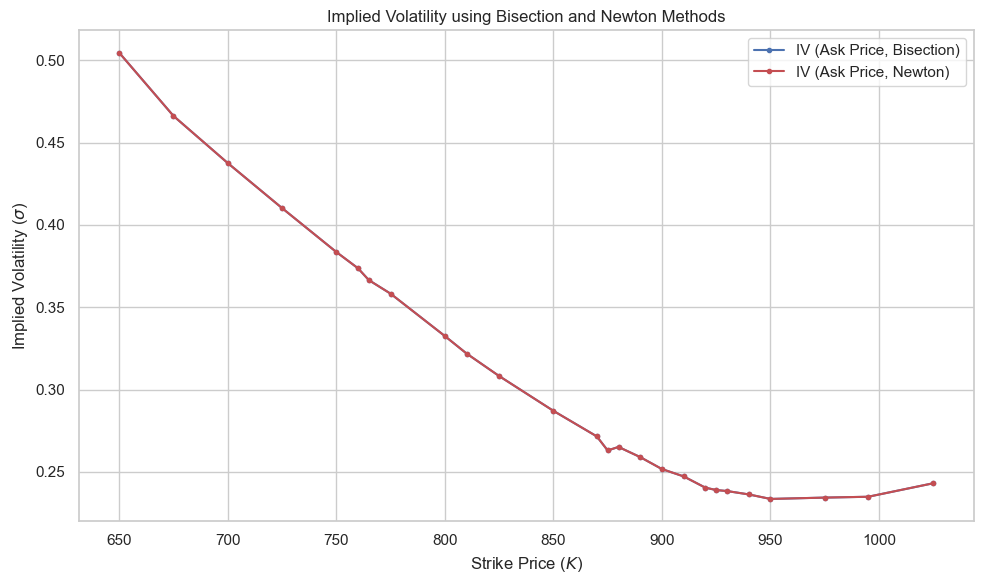

In [11]:
# Comparison of Bisection and Newton Methods
fig, ax = plt.subplots()
ax.plot(K, iv_ask_bisection, 'b.-', label='IV (Ask Price, Bisection)')
ax.plot(K, iv_ask_newton, 'r.-', label='IV (Ask Price, Newton)')
ax.legend()
ax.set_title('Implied Volatility using Bisection and Newton Methods')
ax.set_xlabel(r'Strike Price ($K$)')
ax.set_ylabel(r'Implied Volatility ($\sigma$)')
plt.tight_layout()
plt.show()

As shown in the above figure, the difference between the implied volatility calculated using the two methods (Bisection and Newton) is very small.